# GPU

In [1]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)


import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


import tensorflow as tf
import timeit

Found GPU at: /device:GPU:0


# Import

In [2]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)
import tensorflow as tf
import timeit
# https://keras.io/
!pip install -q keras
import keras

!pip install -q tqdm
import tqdm

Using TensorFlow backend.


In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adagrad
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.monitor_interval = 0

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
from keras import initializers
from keras.utils import np_utils

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('tf')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100


# RBF

In [0]:
from keras.engine import InputSpec, Layer
from keras.legacy import interfaces
#@title COUCHES RBF
###________TROIS CLASSES POUR IMPLEMENTER DES COUCHES RBF________###

class RBFLayer(Layer):
    def __init__(self, alpha=1000.0, alpha_initializer='zeros',
                 alpha_regularizer=None,
                 alpha_constraint=None, 
                 **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.supports_masking = True
        self.alpha_initializer = keras.initializers.Constant(value=1000.0)
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        self.alpha = self.add_weight(shape=(1,),
                                     name='alpha',
                                     initializer=self.alpha_initializer,
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
        self.trainable = False

    def call(self, inputs):
        y = - inputs / self.alpha[0]
        y = keras.backend.exp(y)
        return y

    def get_config(self):
        config = {
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

class RBF(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 sigma = 1000.0,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.sigma = sigma
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        y = - y / self.sigma
        y = keras.backend.exp(y)
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class RBF2(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF2, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Base de données selon un seuil

In [0]:


# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1eyJdoywF4ZLygiQCrC-xfFVPXWr3wRDc'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dossier1.csv')  

#3. Read file as panda dataframe
import pandas as pd
dossier1 = pd.read_csv('dossier1.csv') 

In [0]:
seuil=0.2
good_examples=dossier1[(dossier1.resultat<seuil)]

good_examples=good_examples.drop(['resultat'],axis=1)

In [7]:
good_examples=good_examples.reset_index()
#good_examples=good_examples.drop(['level_0'],axis=1)
good_examples=good_examples.drop(['index'],axis=1)
good_examples.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.999252,-0.999969,-0.999999,-1.000000,-1.000000,-0.999999,-0.999997,-0.999994,-0.999988,-0.999992,...,-1.000000,-1.000000,-1.000000,-0.999998,-0.999981,-0.999987,-0.999998,-1.000000,-0.999999,-0.999975
1,-0.973389,-0.997615,-0.999883,-0.999964,-0.999998,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999993,-0.999708
2,-0.989927,-0.998929,-0.999830,-0.999923,-0.999984,-0.999990,-0.999998,-0.999998,-0.999997,-0.999994,...,-0.983786,-0.994984,-0.998801,-0.999914,-0.999981,-0.999995,-0.999996,-0.999994,-0.999951,-0.999487
3,-0.994017,-0.999552,-0.999935,-0.999907,-0.999976,-0.999996,-0.999999,-1.000000,-0.999999,-0.999999,...,-0.980171,-0.928321,-0.975459,-0.998461,-0.999898,-0.999991,-0.999992,-0.999981,-0.999875,-0.999029
4,-0.995974,-0.999923,-0.999998,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999999,-0.999976,-0.999882,-0.999071


In [0]:
good_examples['target']=0.9

In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5

X_test = (X_test.astype(np.float32) - 127.5)/127.5

In [0]:
xyz=pd.DataFrame(X_train.reshape(60000,28*28))


In [0]:
xyz['target']=0


In [12]:
good_examples.shape

(4543, 785)

In [0]:
xyz.columns=good_examples.columns

In [0]:
xyz=pd.concat([xyz,good_examples],axis=0)

In [0]:
from sklearn.utils import shuffle
xyz=shuffle(xyz)

In [16]:
xyz.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
38544,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
49938,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
37380,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
5197,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
55020,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


# rejector with 1 output

In [0]:
K.set_image_dim_ordering('tf')


In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, np.newaxis]

Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_train = Y_train * 0.9

X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:, :, :,np.newaxis ]
Y_test = np_utils.to_categorical(y_test, nb_classes)
#Y_test = Y_test * 0.9

In [28]:
########################################"True"
from keras import activations, initializers, regularizers, constraints,metrics
from keras.optimizers import Adam, Adagrad
adagrad = Adagrad(lr=0.001, epsilon=None, decay=0.0) #c'est celui-là qui est utilisé pour tous les modèles


# Rejector
rejector= Sequential()
rejector.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(28, 28,1),activation='relu'))
rejector.add(MaxPooling2D(pool_size=(3, 3)))
rejector.add(Conv2D(128, (3, 3), activation='relu') )
rejector.add(MaxPooling2D(pool_size=(3, 3)) )
rejector.add(Dropout(0.25))
rejector.add(Flatten())
rejector.add(Dense(128, activation='relu'))
rejector.add(RBF2(300) )
rejector.add(RBFLayer(alpha=2000.0) )
rejector.add(Dense(1, activation='sigmoid', name='r_output', use_bias=False))


rejector.compile(optimizer=adagrad, loss= 'mse', metrics=['acc'])  #  metrics=['acc', f1, precision, recall])
rejector.summary()

('Shapes : ', TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(300)]), TensorShape([Dimension(None), Dimension(300)]))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
___

In [0]:
from sklearn.model_selection import train_test_split
xyz_train,xyz_val=train_test_split(xyz,test_size=0.2)
y_train=xyz_train.target.values
x_train=xyz_train.drop(['target'],axis=1)
y_val=xyz_val.target.values
x_val=xyz_val.drop(['target'],axis=1)

In [0]:
x_train=x_train.values.astype('float32').reshape(x_train.shape[0],28,28,1)
x_val=x_val.values.astype('float32').reshape(x_val.shape[0],28,28,1)

In [31]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 50 
batch_size = 60
rejector.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch_size, callbacks=[learning_rate_reduction],validation_data = (x_val, y_val))

Train on 51634 samples, validate on 12909 samples
Epoch 1/50
51634/51634 [==============================] - 15s 285us/step - loss: 0.0585 - acc: 0.9232 - val_loss: 0.0530 - val_acc: 0.9297
Epoch 2/50
51634/51634 [==============================] - 14s 278us/step - loss: 0.0530 - acc: 0.9296 - val_loss: 0.0530 - val_acc: 0.9297
Epoch 3/50
 1440/51634 [..............................] - ETA: 13s - loss: 0.0567 - acc: 0.9243

51634/51634 [==============================] - 14s 277us/step - loss: 0.0528 - acc: 0.9296 - val_loss: 0.0524 - val_acc: 0.9297
Epoch 4/50
51634/51634 [==============================] - 14s 275us/step - loss: 0.0500 - acc: 0.9296 - val_loss: 0.0468 - val_acc: 0.9297

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 5/50
16380/51634 [========>.....................] - ETA: 9s - loss: 0.0460 - acc: 0.9306

51634/51634 [==============================] - 14s 276us/step - loss: 0.0453 - acc: 0.9296 - val_loss: 0.0441 - val_acc: 0.9297
Epoch 6/50
51634/51634 [==============================] - 14s 275us/step - loss: 0.0432 - acc: 0.9296 - val_loss: 0.0421 - val_acc: 0.9297
Epoch 7/50
23520/51634 [============>.................] - ETA: 7s - loss: 0.0407 - acc: 0.9323

51634/51634 [==============================] - 14s 276us/step - loss: 0.0417 - acc: 0.9296 - val_loss: 0.0404 - val_acc: 0.9297

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 8/50
51634/51634 [==============================] - 14s 275us/step - loss: 0.0407 - acc: 0.9296 - val_loss: 0.0398 - val_acc: 0.9297
Epoch 9/50
11700/51634 [=====>........................] - ETA: 10s - loss: 0.0416 - acc: 0.9275

51634/51634 [==============================] - 14s 277us/step - loss: 0.0402 - acc: 0.9296 - val_loss: 0.0393 - val_acc: 0.9297
Epoch 10/50
51634/51634 [==============================] - 14s 276us/step - loss: 0.0397 - acc: 0.9296 - val_loss: 0.0388 - val_acc: 0.9297

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.000125000005937.
Epoch 11/50
18060/51634 [=========>....................] - ETA: 8s - loss: 0.0388 - acc: 0.9303

51634/51634 [==============================] - 14s 276us/step - loss: 0.0393 - acc: 0.9296 - val_loss: 0.0386 - val_acc: 0.9297
Epoch 12/50
51634/51634 [==============================] - 14s 276us/step - loss: 0.0392 - acc: 0.9296 - val_loss: 0.0384 - val_acc: 0.9297
Epoch 13/50
23520/51634 [============>.................] - ETA: 7s - loss: 0.0402 - acc: 0.9280

51634/51634 [==============================] - 14s 275us/step - loss: 0.0390 - acc: 0.9296 - val_loss: 0.0383 - val_acc: 0.9297

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.
Epoch 14/50
51634/51634 [==============================] - 14s 273us/step - loss: 0.0389 - acc: 0.9296 - val_loss: 0.0382 - val_acc: 0.9297
Epoch 15/50
11760/51634 [=====>........................] - ETA: 10s - loss: 0.0413 - acc: 0.9259

51634/51634 [==============================] - 14s 274us/step - loss: 0.0388 - acc: 0.9296 - val_loss: 0.0381 - val_acc: 0.9297
Epoch 16/50
51634/51634 [==============================] - 14s 277us/step - loss: 0.0388 - acc: 0.9296 - val_loss: 0.0381 - val_acc: 0.9297

Epoch 00016: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.
Epoch 17/50
18180/51634 [=========>....................] - ETA: 8s - loss: 0.0390 - acc: 0.9303

51634/51634 [==============================] - 14s 274us/step - loss: 0.0387 - acc: 0.9296 - val_loss: 0.0380 - val_acc: 0.9297
Epoch 18/50
51634/51634 [==============================] - 14s 275us/step - loss: 0.0387 - acc: 0.9296 - val_loss: 0.0380 - val_acc: 0.9297
Epoch 19/50
24000/51634 [============>.................] - ETA: 7s - loss: 0.0392 - acc: 0.9277

51634/51634 [==============================] - 14s 276us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0380 - val_acc: 0.9297

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.
Epoch 20/50
51634/51634 [==============================] - 14s 276us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 21/50
11880/51634 [=====>........................] - ETA: 10s - loss: 0.0404 - acc: 0.9274

51634/51634 [==============================] - 14s 274us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 22/50
51634/51634 [==============================] - 14s 274us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 23/50
18840/51634 [=========>....................] - ETA: 8s - loss: 0.0391 - acc: 0.9279

51634/51634 [==============================] - 14s 278us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 24/50
51634/51634 [==============================] - 14s 277us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 25/50
22860/51634 [============>.................] - ETA: 7s - loss: 0.0392 - acc: 0.9282

51634/51634 [==============================] - 14s 277us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 26/50
51634/51634 [==============================] - 14s 275us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 27/50
24900/51634 [=============>................] - ETA: 6s - loss: 0.0400 - acc: 0.9273

51634/51634 [==============================] - 14s 274us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 28/50
51634/51634 [==============================] - 14s 273us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9297
Epoch 29/50
25260/51634 [=============>................] - ETA: 6s - loss: 0.0389 - acc: 0.9298

51634/51634 [==============================] - 14s 275us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 30/50
51634/51634 [==============================] - 14s 276us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 31/50
25320/51634 [=============>................] - ETA: 6s - loss: 0.0394 - acc: 0.9275

51634/51634 [==============================] - 14s 277us/step - loss: 0.0386 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 32/50
51634/51634 [==============================] - 14s 277us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 33/50
25020/51634 [=============>................] - ETA: 6s - loss: 0.0389 - acc: 0.9289

51634/51634 [==============================] - 14s 277us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 34/50
51634/51634 [==============================] - 14s 278us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 35/50
23940/51634 [============>.................] - ETA: 7s - loss: 0.0382 - acc: 0.9292

51634/51634 [==============================] - 14s 279us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 36/50
51634/51634 [==============================] - 14s 273us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 37/50
25320/51634 [=============>................] - ETA: 6s - loss: 0.0398 - acc: 0.9269

51634/51634 [==============================] - 14s 275us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 38/50
51634/51634 [==============================] - 14s 275us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 39/50
25140/51634 [=============>................] - ETA: 6s - loss: 0.0385 - acc: 0.9300

51634/51634 [==============================] - 14s 276us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 40/50
51634/51634 [==============================] - 14s 278us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 41/50
25440/51634 [=============>................] - ETA: 6s - loss: 0.0389 - acc: 0.9283

51634/51634 [==============================] - 14s 273us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0378 - val_acc: 0.9297
Epoch 42/50
51634/51634 [==============================] - 14s 274us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 43/50
25320/51634 [=============>................] - ETA: 6s - loss: 0.0387 - acc: 0.9291

51634/51634 [==============================] - 14s 277us/step - loss: 0.0385 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 44/50
51634/51634 [==============================] - 14s 274us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 45/50
25380/51634 [=============>................] - ETA: 6s - loss: 0.0387 - acc: 0.9291

51634/51634 [==============================] - 14s 275us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 46/50
51634/51634 [==============================] - 14s 277us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 47/50
25260/51634 [=============>................] - ETA: 6s - loss: 0.0389 - acc: 0.9283

51634/51634 [==============================] - 14s 274us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 48/50
51634/51634 [==============================] - 14s 274us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 49/50
25860/51634 [==============>...............] - ETA: 6s - loss: 0.0383 - acc: 0.9298

51634/51634 [==============================] - 14s 277us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297
Epoch 50/50
51634/51634 [==============================] - 14s 272us/step - loss: 0.0384 - acc: 0.9296 - val_loss: 0.0377 - val_acc: 0.9297


In [0]:
y_pred=rejector.predict(x_val)

In [0]:
Y_pred=[]
Y_val=[]
for i in range (y_pred.shape[0]):
  Y_pred.append(y_pred[i].item())
  if y_val[i].item() !=0:
    Y_val.append(1)
  else:
    Y_val.append(0)


In [0]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,_=roc_curve(Y_val, Y_pred)
roc_auc=auc(fpr,tpr)

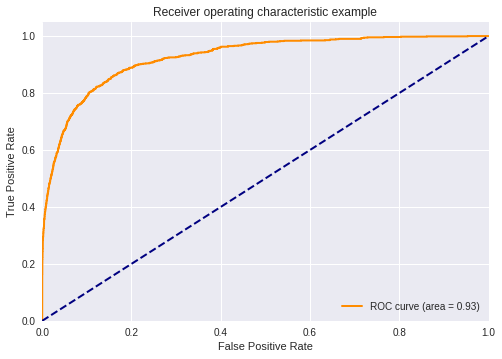

In [35]:
#seuil=0.2
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
y_rej_pred=rejector.predict(X_test)

In [37]:
max(y_rej_pred)

array([0.43788433], dtype=float32)

In [42]:
##### dessiner en fonction des seuil 
Point=[]
for j in range (1,500):
  Y_test_new=[]
  X_test_new=[]
  Y_rejet_new=[]
  X_rejet_new=[]

  for i in range(len (y_rej_pred)): 
    if y_rej_pred[i].item()<=float(j)/1000: 
      X_test_new.append(X_test[i,:,:,:])
      Y_test_new.append(y_test[i])  
    else:
      X_rejet_new.append(X_test[i,:,:,:])
      Y_rejet_new.append(y_test[i])  
    
  X_test_new=np.reshape(X_test_new, (len(X_test_new),28,28,1))
  X_rejet_new=np.reshape(X_rejet_new, (len(X_rejet_new),28,28,1))
  Y_rejet_new=np.array(Y_rejet_new)
  Y_test_new=np.array(Y_test_new)

  Y_test_new = np_utils.to_categorical(Y_test_new, 10)
  Y_rejet_new = np_utils.to_categorical(Y_rejet_new, 10)


  if Y_test_new.shape!=(0,):
    liste=model_95.evaluate(X_test_new,Y_test_new)
    if liste!=[]:
      Point.append((float(j)/100,liste[1]))
  
  #Point.append(liste[1])
  
  
 # l'AUC



2683/2683 [==============================] - 1s 224us/step


3232/5418 [================>.............] - ETA: 0s

5344/6863 [======================>.......] - ETA: 0s

 288/7874 [>.............................] - ETA: 1s

4288/8473 [==============>...............] - ETA: 0s

2816/8866 [========>.....................] - ETA: 1s

1024/9131 [==>...........................] - ETA: 1s

  32/9306 [..............................] - ETA: 1s

8800/9433 [==========================>...] - ETA: 0s

9520/9520 [==============================] - 2s 209us/step


7840/9605 [=======================>......] - ETA: 0s

8288/9660 [========================>.....] - ETA: 0s

8736/9701 [==========================>...] - ETA: 0s

8992/9749 [==========================>...] - ETA: 0s

9024/9790 [==========================>...] - ETA: 0s

9216/9815 [===========================>..] - ETA: 0s

9152/9836 [==========================>...] - ETA: 0s

8544/9851 [=========================>....] - ETA: 0s

8480/9867 [========================>.....] - ETA: 0s

8640/9887 [=========================>....] - ETA: 0s

8704/9904 [=========================>....] - ETA: 0s

8128/9913 [=======================>......] - ETA: 0s

8608/9924 [=========================>....] - ETA: 0s

8832/9935 [=========================>....] - ETA: 0s

8096/9945 [=======================>......] - ETA: 0s

8864/9952 [=========================>....] - ETA: 0s

8480/9956 [========================>.....] - ETA: 0s

8480/9961 [========================>.....] - ETA: 0s

8864/9967 [=========================>....] - ETA: 0s

8736/9970 [=========================>....] - ETA: 0s

8896/9974 [=========================>....] - ETA: 0s

9184/9975 [==========================>...] - ETA: 0s

9056/9979 [==========================>...] - ETA: 0s

8672/9983 [=========================>....] - ETA: 0s

8672/9986 [=========================>....] - ETA: 0s

8576/9987 [========================>.....] - ETA: 0s

9888/9988 [============================>.] - ETA: 0s

8672/9989 [=========================>....] - ETA: 0s

8384/9990 [========================>.....] - ETA: 0s

9024/9993 [==========================>...] - ETA: 0s

9152/9995 [==========================>...] - ETA: 0s

8896/9995 [=========================>....] - ETA: 0s

8928/9995 [=========================>....] - ETA: 0s

9056/9996 [==========================>...] - ETA: 0s

9216/9997 [==========================>...] - ETA: 0s

8512/9997 [========================>.....] - ETA: 0s

8960/9998 [=========================>....] - ETA: 0s

9440/9999 [===========================>..] - ETA: 0s

 9088/10000 [==========================>...] - ETA: 0s

 7232/10000 [====================>.........] - ETA: 0s

 6944/10000 [===================>..........] - ETA: 0s

 7040/10000 [====================>.........] - ETA: 0s

 7424/10000 [=====================>........] - ETA: 0s

 7488/10000 [=====================>........] - ETA: 0s

 7616/10000 [=====================>........] - ETA: 0s

 7360/10000 [=====================>........] - ETA: 0s

10000/10000 [==============================] - 2s 206us/step


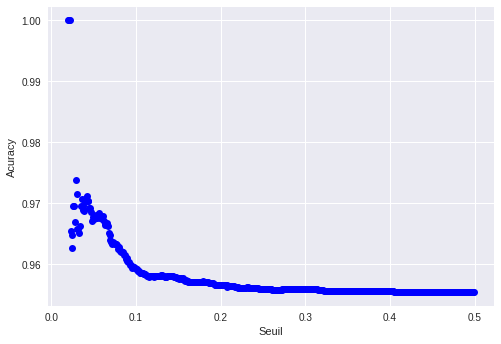

In [43]:
X=[]
Y=[]
for point in Point:
  X.append(point[0]/10)
  Y.append(point[1])
  
plt.xlabel("Seuil")
plt.ylabel("Acuracy")
plt.plot(X,Y,marker='o',color='b',ls='')
plt.show()

In [39]:
from google.colab import files
uploaded = files.upload()

In [40]:
model_95=keras.models.load_model('10_classifier (1)')